In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import imutils
import ipywidgets

from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import chart_studio.plotly  as py
from chart_studio.plotly import iplot
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
import random


In [44]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    

In [45]:
df = pd.read_csv("data.csv")
df.head()

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,ch9,ch10,ch11,ch12,ch13,ch14,ch15,label
0,-0.084833,0.336391,0.727666,0.284861,0.157216,0.150551,0.299531,0.145583,-0.026877,0.055283,0.000155,-0.111373,0.082754,0.028478,-0.023124,5.5
1,-0.046846,0.289916,0.538304,0.174659,0.194968,0.062330,0.227172,0.090609,0.020410,0.020337,-0.002328,-0.095761,0.071228,0.015774,-0.012425,5.5
2,-0.047517,0.263150,0.574644,0.187919,0.198232,0.091427,0.166249,0.101292,0.029889,0.016017,-0.003360,-0.094898,0.071989,0.014139,-0.015784,5.5
3,-0.043622,0.259777,0.472857,0.145080,0.184822,0.000898,0.089452,0.083603,0.053789,-0.008042,-0.007052,-0.088583,0.062830,0.009523,-0.006107,5.5
4,-0.052821,0.249013,0.505147,0.149475,0.212153,0.056851,0.121410,0.111416,0.107618,-0.001524,-0.003577,-0.089234,0.066249,0.011462,-0.010132,5.5


<AxesSubplot:xlabel='label', ylabel='count'>

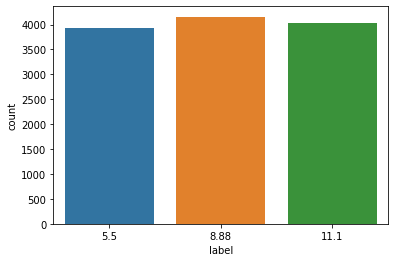

In [46]:
# Visualize the imblance in the dataset
sns.countplot(x = 'label', data=df)

In [47]:
#decode the label to numerical value
df['label'] = df['label'].astype('category')
class2idx = {
    5.5: 0,
    8.88: 1,
    11.1: 2,
}


idx2class = {v: k for k, v in class2idx.items()}


df['label'].replace(class2idx, inplace=True)

In [48]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

In [49]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1,  random_state=21)

In [50]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [51]:
def get_class_distribution(obj):
    count_dict = {
        "5.55": 0,
        "8.88": 0,
        "11.1": 0
    }
    
    for i in obj:
#         print(i)
        if i == 0: 
            count_dict['5.55'] += 1
        elif i == 1: 
            count_dict['8.88'] += 1
        elif i == 2: 
            count_dict['11.1'] += 1         
#         else:
#             print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

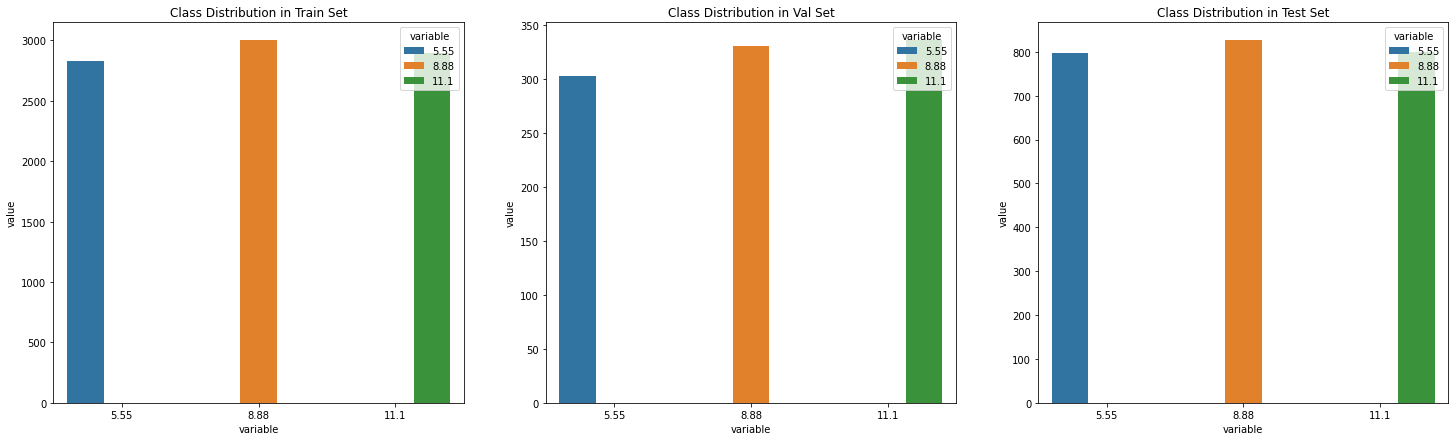

In [52]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

In [85]:
EPOCHS = 30
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [86]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)





In [87]:
train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [88]:
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

In [89]:
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)

tensor([0.0004, 0.0003, 0.0003])


In [90]:
class_weights_all = class_weights[target_list]

In [91]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [92]:
EPOCHS = 30
BATCH_SIZE = 16
LEARNING_RATE = 0.0007
NUM_FEATURES = len(X.columns)
NUM_CLASSES = 3

In [93]:
print(NUM_FEATURES)

15


In [94]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=weighted_sampler
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1, drop_last=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, drop_last=True)

In [95]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [96]:
# class MulticlassClassification(nn.Module):
#     def __init__(self, num_feature, num_class):
#         super(MulticlassClassification, self).__init__()
        
#         self.layer_1 = nn.Linear(num_feature, 512)
#         self.layer_2 = nn.Linear(512, 64)
#         self.layer_out = nn.Linear(64, num_class) 
        
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(p=0.2)
#         self.batchnorm1 = nn.BatchNorm1d(512)
#         self.batchnorm2 = nn.BatchNorm1d(64)
        
#     def forward(self, x):
#         x = self.layer_1(x)
#         x = self.batchnorm1(x)
#         x = self.relu(x)
        
#         x = self.layer_2(x)
#         x = self.batchnorm2(x)
#         x = self.relu(x)
#         x = self.dropout(x)
        
        
#         x = self.layer_out(x)
        
#         return x

In [97]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [98]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=15, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=3, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)


In [99]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [100]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [101]:
print("Begin training.")

for e in range(1, EPOCHS+1):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0

    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()

    
        
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')
        


Begin training.
Epoch 001: | Train Loss: 0.12740 | Val Loss: 0.01367 | Train Acc: 97.159| Val Acc: 99.588
Epoch 002: | Train Loss: 0.00861 | Val Loss: 0.00376 | Train Acc: 99.824| Val Acc: 99.794
Epoch 003: | Train Loss: 0.00440 | Val Loss: 0.00367 | Train Acc: 99.846| Val Acc: 99.794
Epoch 004: | Train Loss: 0.00240 | Val Loss: 0.00197 | Train Acc: 99.945| Val Acc: 99.897
Epoch 005: | Train Loss: 0.00639 | Val Loss: 0.00130 | Train Acc: 99.835| Val Acc: 100.000
Epoch 006: | Train Loss: 0.00478 | Val Loss: 0.01038 | Train Acc: 99.868| Val Acc: 99.794
Epoch 007: | Train Loss: 0.00125 | Val Loss: 0.00638 | Train Acc: 99.978| Val Acc: 99.794
Epoch 008: | Train Loss: 0.00307 | Val Loss: 0.00520 | Train Acc: 99.912| Val Acc: 99.794
Epoch 009: | Train Loss: 0.00148 | Val Loss: 0.00128 | Train Acc: 99.934| Val Acc: 99.897
Epoch 010: | Train Loss: 0.00022 | Val Loss: 0.00464 | Train Acc: 100.000| Val Acc: 99.794
Epoch 011: | Train Loss: 0.00119 | Val Loss: 0.00243 | Train Acc: 99.967| Val Acc:

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

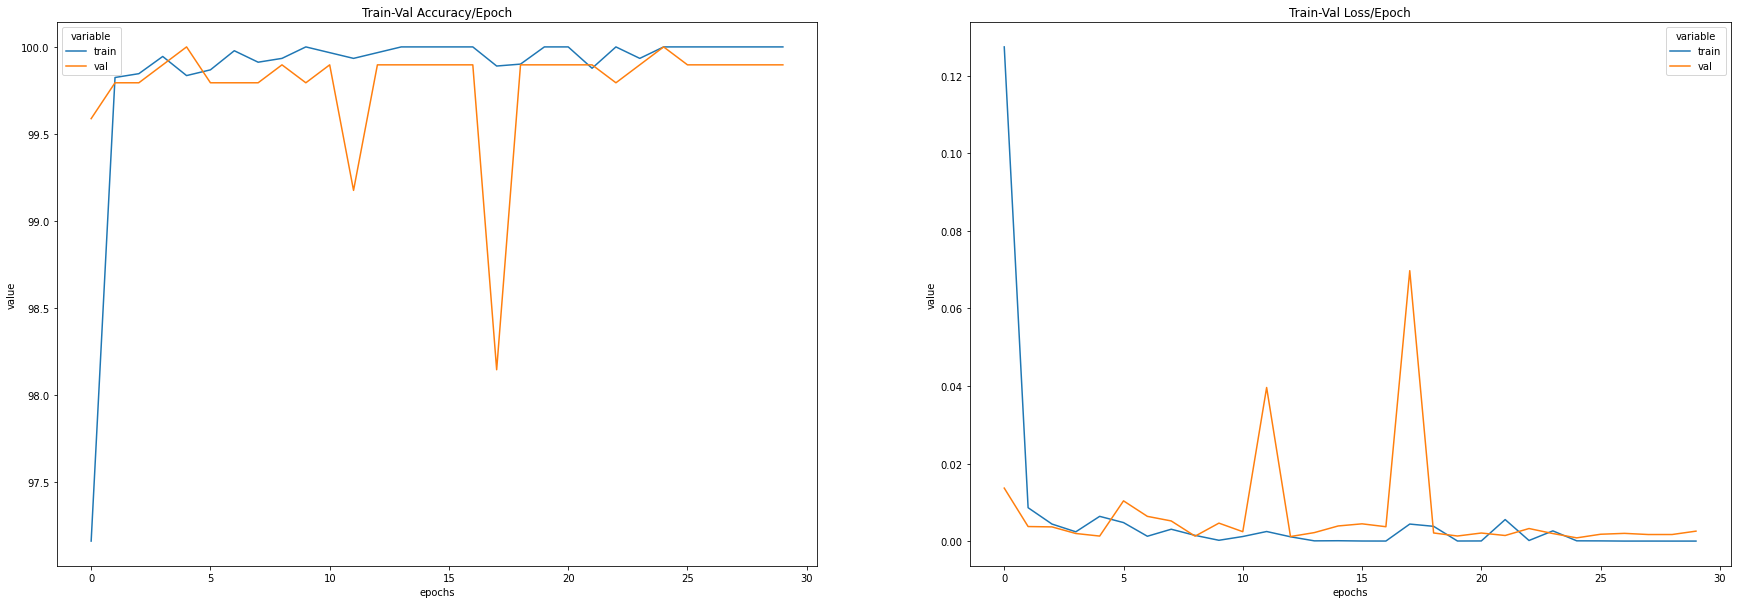

In [103]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [104]:
y_pred_list = []

with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_softmax = torch.log_softmax(y_test_pred, dim = 1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())

In [105]:
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

Text(0.5, 1.0, 'Confusion Matrix for MAV Features')

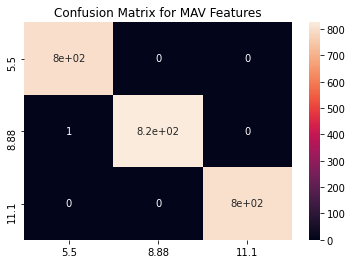

In [106]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list)).rename(columns=idx2class, index=idx2class)
sns.heatmap(confusion_matrix_df, annot=True)
plt.title('Confusion Matrix for MAV Features')

In [336]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       134
           1       1.00      1.00      1.00       107
           2       1.00      1.00      1.00       108
           3       1.00      1.00      1.00       118
           4       1.00      1.00      1.00       121

    accuracy                           1.00       588
   macro avg       1.00      1.00      1.00       588
weighted avg       1.00      1.00      1.00       588

